In [91]:
import torch
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from matplotlib import cm
import time
from tqdm import tqdm
import matplotlib
import matplotlib.colors as mcolors


In [2]:
# make sure to aws sync before this one
dirs = glob.glob("s3/*/*/model.tar.gz")
for run in tqdm(dirs):
    path = os.path.dirname(run)
    os.system(f"cd {path}; tar -xzvf model.tar.gz")
    # print(os.getcwd())

  0%|          | 0/66 [00:00<?, ?it/s]x big_losses-485-0-100000.pkl
x model-485-0-100000.pth
x losses-485-0-100000.pkl
  2%|▏         | 1/66 [00:00<00:12,  5.21it/s]x big_losses-485-0-100000-0.4.pkl
x model-485-0-100000-0.4.pth
x losses-485-0-100000-0.4.pkl
  3%|▎         | 2/66 [00:00<00:11,  5.34it/s]x big_losses-85-0-100000-0.4.pkl
x losses-85-0-100000-0.4.pkl
x model-85-0-100000-0.4.pth
  5%|▍         | 3/66 [00:00<00:11,  5.45it/s]x big_losses-410-0-100000-0.2.pkl
x losses-410-0-100000-0.2.pkl
x model-410-0-100000-0.2.pth
  6%|▌         | 4/66 [00:00<00:11,  5.42it/s]x losses-340-0-10-0.8.pkl
x big_losses-340-0-10-0.8.pkl
x model-340-0-10-0.8.pth
x model-435-0-100000.pth
x big_losses-435-0-100000.pkl
x losses-435-0-100000.pkl
  9%|▉         | 6/66 [00:00<00:08,  7.34it/s]x model-485-0-100000-0.2.pth
x losses-485-0-100000-0.2.pkl
x big_losses-485-0-100000-0.2.pkl
 11%|█         | 7/66 [00:01<00:08,  6.73it/s]x big_losses-485-0-100000-0.8.pkl
x model-485-0-100000-0.8.pth
x losses-48

In [3]:
# load all s3 runs; i messed up and have duplicates with the same replica ids
s3_hiddens = []
s3_alphas = []
s3_loss_list = []
s3_file_names = []
# loss_dict = {}
# big_loss_dict = {}

for run in dirs:
    parent_dir = os.path.dirname(run)
    loss_file = glob.glob(f"{parent_dir}/losses*pkl")[0]
    big_loss_file = glob.glob(f"{parent_dir}/big_losses*pkl")[0]
    # read off replica id (defunct), run count, alpha
    parts = os.path.splitext(os.path.basename(loss_file))[0].split('-')

    count = parts[3]
    if int(count) != 100000:
        continue

    hidden_size = int(parts[1])
    if len(parts) == 4:
        alpha = 0.4
    else:
        alpha = float(parts[4])
    
    s3_file_names.append(loss_file)
    s3_hiddens.append(hidden_size)
    s3_alphas.append(alpha)
    with open(loss_file, "rb") as f:
        loss = np.array(pickle.load(f))
    
    # with open(big_loss_file, "rb") as f:
    #     big_loss = pickle.load(f)

    s3_loss_list.append(loss)
    # if (hidden_size, alpha) in loss_dict.keys():
    #     loss_dict[(hidden_size, alpha)].append(loss)
    #     # big_loss_dict[(hidden_size, alpha)].append(big_loss)
    # else:
    #     loss_dict[(hidden_size, alpha)] = [loss]
    #     # big_loss_dict[(hidden_size, alpha)] = [big_loss]


In [4]:
meta_df = pd.DataFrame({"hidden_size": s3_hiddens, "alpha": s3_alphas, "file_name": s3_file_names})
loss_df = pd.DataFrame(s3_loss_list)

s3_df = pd.merge(meta_df, loss_df, left_index = True, right_index = True)

In [5]:
s3_df.head()

hidden_size  alpha                                          file_name   
0          485    0.4  s3/pytorch-training-2023-05-02-09-48-29-174/ou...  \
1          485    0.4  s3/pytorch-training-2023-05-03-02-48-01-783/ou...   
2           85    0.4  s3/pytorch-training-2023-05-03-08-34-21-803/ou...   
3          410    0.2  s3/pytorch-training-2023-05-03-02-47-58-224/ou...   
4          435    0.4  s3/pytorch-training-2023-05-02-08-48-24-458/ou...   

          0         1         2         3         4         5         6  ...   
0  0.693651  0.710719  0.694618  0.696948  0.701665  0.697870  0.694510  ...  \
1  0.694360  0.710775  0.695451  0.696960  0.700895  0.699226  0.694096  ...   
2  0.696258  0.693838  0.694824  0.694984  0.693827  0.693512  0.693871  ...   
3  0.693544  0.693280  0.694088  0.696846  0.693321  0.696114  0.694844  ...   
4  0.693565  0.705117  0.694048  0.699163  0.699558  0.696406  0.693463  ...   

      99990     99991     99992     99993     99994     99995     99996   
0  0.093634  0.096353  0.095517  0.093114  0.093131  0.100089  0.098658  \
1  0.102460  0.105402  0.105412  0.103500  0.103373  0.110556  0.107192   
2  0.256797  0.259008  0.258429  0.261614  0.257263  0.262287  0.260340   
3  0.174247  0.178803  0.176962  0.177551  0.175860  0.182292  0.180223   
4  0.101719  0.105519  0.105046  0.102694  0.102594  0.109083  0.106780   

      99997     99998     99999  
0  0.095612  0.094385  0.095948  
1  0.105050  0.103529  0.106876  
2  0.260835  0.258909  0.261390  
3  0.179771  0.176434  0.179548  
4  0.103984  0.102877  0.104884  

[5 rows x 100003 columns]

In [6]:
loss_files = glob.glob('s3/losses/losses*pkl')

alphas = []
hiddens = []
file_names = []
losses = []

for f in loss_files:
    # print(f)
    f_name = os.path.basename(f)
    f_name = os.path.splitext(f_name)[0]

    mod_size = int(f_name.split('-')[1])
    repl_id = f_name.split('-')[2]
    step_count = f_name.split('-')[3].split('.')[0]
    if len(f_name.split('-')) > 4:
        alpha = float(f_name.split('-')[-1])
    else:
        alpha = 0.4

    if int(step_count) == 100000:
        with open(f, "rb") as file:
            duplicate = False
            curr_l = pickle.load(file)
            #check if equals losses from any previous dataframe
            for l in s3_loss_list:
                if np.all(l == curr_l):
                    duplicate = True
                    break
            if duplicate:
                continue

            alphas.append(alpha)
            hiddens.append(mod_size)
            file_names.append(f)
            losses.append(curr_l)
            # losses_dict[(int(mod_size), float(alpha), repl_id)] = pickle.load(file)


In [7]:
file_names

['s3/losses/losses-90-sm2222-100000-0.2.pkl',
 's3/losses/losses-210-sm3333-100000.pkl',
 's3/losses/losses-485-sm1111-100000-0.8.pkl',
 's3/losses/losses-485-cc-100000-0.8.pkl',
 's3/losses/losses-485-sm5555-100000-0.2.pkl',
 's3/losses/losses-340-c-100000-0.2.pkl',
 's3/losses/losses-90-arjun-100000-0.8.pkl',
 's3/losses/losses-110-c-100000-0.8.pkl',
 's3/losses/losses-200-sm4444-100000-0.2.pkl',
 's3/losses/losses-485-1111-100000-0.8.pkl',
 's3/losses/losses-435-c-100000.pkl',
 's3/losses/losses-460-c-100000.pkl',
 's3/losses/losses-485-11111-100000-0.2.pkl',
 's3/losses/losses-135-sm3333-100000-0.2.pkl',
 's3/losses/losses-240-sm5555-100000-0.2.pkl',
 's3/losses/losses-35-sm5555-100000-0.2.pkl',
 's3/losses/losses-160-sm4444-100000-0.2.pkl',
 's3/losses/losses-550-sm1111-100000-0.8.pkl',
 's3/losses/losses-210-sm4444b-100000.pkl',
 's3/losses/losses-485-1-100000.pkl',
 's3/losses/losses-80-ccc-100000-0.2.pkl',
 's3/losses/losses-485-ccc-100000-0.8.pkl',
 's3/losses/losses-65-sm1111

In [8]:
meta_df = pd.DataFrame({"hidden_size": hiddens, "alpha": alphas, "file_name": file_names})
loss_df = pd.DataFrame(losses)

supp_df = pd.merge(meta_df, loss_df, left_index = True, right_index = True).reset_index(drop = True)

In [9]:
supp_df.head()

hidden_size  alpha                                   file_name         0   
0           90    0.2   s3/losses/losses-90-sm2222-100000-0.2.pkl  0.694798  \
1          210    0.4      s3/losses/losses-210-sm3333-100000.pkl  0.694413   
2          485    0.8  s3/losses/losses-485-sm1111-100000-0.8.pkl  0.693519   
3          485    0.8      s3/losses/losses-485-cc-100000-0.8.pkl  0.693690   
4          485    0.2  s3/losses/losses-485-sm5555-100000-0.2.pkl  0.693968   

          1         2         3         4         5         6  ...     99990   
0  0.693995  0.694103  0.693493  0.693288  0.693861  0.693832  ...  0.313620  \
1  0.697200  0.694028  0.693879  0.695317  0.694204  0.693769  ...  0.128353   
2  0.707581  0.693543  0.699234  0.699302  0.695735  0.693720  ...  0.033785   
3  0.707773  0.693643  0.700022  0.699274  0.695728  0.693254  ...  0.031142   
4  0.715033  0.695578  0.698914  0.703384  0.699118  0.695193  ...  0.165829   

      99991     99992     99993     99994     99995     99996     99997   
0  0.311219  0.312933  0.315957  0.313628  0.317533  0.316894  0.317684  \
1  0.132392  0.133429  0.128815  0.129577  0.136679  0.133341  0.132049   
2  0.032895  0.035483  0.032860  0.033492  0.035209  0.035082  0.035051   
3  0.030897  0.033252  0.030498  0.031430  0.032746  0.032531  0.033261   
4  0.168112  0.167066  0.168291  0.166103  0.172734  0.168521  0.169791   

      99998     99999  
0  0.316948  0.315067  
1  0.129169  0.132766  
2  0.033477  0.033802  
3  0.030990  0.031739  
4  0.166266  0.170035  

[5 rows x 100003 columns]

In [10]:
total_df = pd.concat([s3_df, supp_df]).reset_index(drop=True)

In [11]:
total_df

hidden_size  alpha                                          file_name   
0           485    0.4  s3/pytorch-training-2023-05-02-09-48-29-174/ou...  \
1           485    0.4  s3/pytorch-training-2023-05-03-02-48-01-783/ou...   
2            85    0.4  s3/pytorch-training-2023-05-03-08-34-21-803/ou...   
3           410    0.2  s3/pytorch-training-2023-05-03-02-47-58-224/ou...   
4           435    0.4  s3/pytorch-training-2023-05-02-08-48-24-458/ou...   
..          ...    ...                                                ...   
93           35    0.4           s3/losses/losses-35-arjun-100000-0.4.pkl   
94           35    0.8         s3/losses/losses-35-sm4444a-100000-0.8.pkl   
95          110    0.2         s3/losses/losses-110-sm2222-100000-0.2.pkl   
96          210    0.4            s3/losses/losses-210-sm2222b-100000.pkl   
97          285    0.2         s3/losses/losses-285-sm5555-100000-0.2.pkl   

           0         1         2         3         4         5         6  ...   
0   0.693651  0.710719  0.694618  0.696948  0.701665  0.697870  0.694510  ...  \
1   0.694360  0.710775  0.695451  0.696960  0.700895  0.699226  0.694096  ...   
2   0.696258  0.693838  0.694824  0.694984  0.693827  0.693512  0.693871  ...   
3   0.693544  0.693280  0.694088  0.696846  0.693321  0.696114  0.694844  ...   
4   0.693565  0.705117  0.694048  0.699163  0.699558  0.696406  0.693463  ...   
..       ...       ...       ...       ...       ...       ...       ...  ...   
93  0.694491  0.694115  0.693962  0.694385  0.693913  0.693645  0.693868  ...   
94  0.695143  0.693671  0.693739  0.693716  0.693901  0.693751  0.693385  ...   
95  0.694551  0.694747  0.693966  0.693886  0.693676  0.693390  0.693899  ...   
96  0.695257  0.696767  0.695316  0.694014  0.694365  0.694998  0.693865  ...   
97  0.694002  0.694200  0.695016  0.693505  0.693921  0.693775  0.693741  ...   

       99990     99991     99992     99993     99994     99995     99996   
0   0.093634  0.096353  0.095517  0.093114  0.093131  0.100089  0.098658  \
1   0.102460  0.105402  0.105412  0.103500  0.103373  0.110556  0.107192   
2   0.256797  0.259008  0.258429  0.261614  0.257263  0.262287  0.260340   
3   0.174247  0.178803  0.176962  0.177551  0.175860  0.182292  0.180223   
4   0.101719  0.105519  0.105046  0.102694  0.102594  0.109083  0.106780   
..       ...       ...       ...       ...       ...       ...       ...   
93  0.308952  0.309215  0.310989  0.311957  0.311956  0.317122  0.310805   
94  0.184519  0.188143  0.188160  0.187217  0.186755  0.192412  0.189094   
95  0.288860  0.291719  0.293128  0.292815  0.289879  0.294877  0.293688   
96  0.128580  0.132214  0.133751  0.130966  0.131653  0.138658  0.135156   
97  0.209992  0.213145  0.212099  0.212621  0.210172  0.218041  0.215437   

       99997     99998     99999  
0   0.095612  0.094385  0.095948  
1   0.105050  0.103529  0.106876  
2   0.260835  0.258909  0.261390  
3   0.179771  0.176434  0.179548  
4   0.103984  0.102877  0.104884  
..       ...       ...       ...  
93  0.314768  0.311969  0.314694  
94  0.187953  0.186217  0.188462  
95  0.294791  0.292540  0.295698  
96  0.132330  0.129525  0.134123  
97  0.215346  0.211962  0.215244  

[98 rows x 100003 columns]

In [12]:
# total_df.to_csv("data-5-3-11am.csv")

In [13]:
with open("df-5-3-5pm.pkl", "wb") as f:
    pickle.dump(total_df, f)

In [25]:
total_df[(total_df['alpha'] == 0.4) & total_df['hidden_size'].isin([85, 210, 485]) ].sort_values('hidden_size')

level_0  hidden_size  alpha   
41       41           85    0.4  \
2         2           85    0.4   
7         7           85    0.4   
12       12           85    0.4   
14       14           85    0.4   
18       18           85    0.4   
21       21           85    0.4   
42       42           85    0.4   
51       51           85    0.4   
87       31          210    0.4   
83       27          210    0.4   
82       26          210    0.4   
80       24          210    0.4   
79       23          210    0.4   
74       18          210    0.4   
57        1          210    0.4   
95       39          210    0.4   
8         8          210    0.4   
91       35          485    0.4   
75       19          485    0.4   
36       36          485    0.4   
15       15          485    0.4   
9         9          485    0.4   
1         1          485    0.4   
54       54          485    0.4   
0         0          485    0.4   

                                            file_name         0         1   
41  s3/pytorch-training-2023-05-02-14-36-03-849/ou...  0.699241  0.693456  \
2   s3/pytorch-training-2023-05-03-08-34-21-803/ou...  0.696258  0.693838   
7   s3/pytorch-training-2023-05-03-07-46-49-093/ou...  0.693744  0.696555   
12  s3/pytorch-training-2023-05-03-07-46-53-037/ou...  0.694358  0.694326   
14  s3/pytorch-training-2023-05-03-07-46-54-117/ou...  0.694418  0.695530   
18  s3/pytorch-training-2023-05-03-07-46-51-293/ou...  0.693960  0.694565   
21  s3/pytorch-training-2023-05-03-07-46-50-599/ou...  0.700328  0.694386   
42  s3/pytorch-training-2023-05-03-07-46-52-319/ou...  0.694691  0.694164   
51  s3/pytorch-training-2023-05-03-07-46-47-974/ou...  0.699392  0.693751   
87             s3/losses/losses-210-sm2222-100000.pkl  0.693654  0.698489   
83            s3/losses/losses-210-sm5555a-100000.pkl  0.695299  0.697055   
82             s3/losses/losses-210-sm4444-100000.pkl  0.694331  0.699081   
80            s3/losses/losses-210-sm3333b-100000.pkl  0.695179  0.697897   
79          s3/losses/losses-210-arjun-100000-0.4.pkl  0.693660  0.698125   
74            s3/losses/losses-210-sm4444b-100000.pkl  0.693757  0.699789   
57             s3/losses/losses-210-sm3333-100000.pkl  0.694413  0.697200   
95            s3/losses/losses-210-sm2222b-100000.pkl  0.695257  0.696767   
8   s3/pytorch-training-2023-05-02-03-40-00-009/ou...  0.694258  0.699433   
91             s3/losses/losses-485-cc-100000-0.4.pkl  0.695272  0.707454   
75                  s3/losses/losses-485-1-100000.pkl  0.694635  0.709406   
36  s3/pytorch-training-2023-05-03-02-48-02-846/ou...  0.695096  0.709459   
15  s3/pytorch-training-2023-05-03-02-48-05-551/ou...  0.693578  0.697943   
9   s3/pytorch-training-2023-05-03-02-48-00-804/ou...  0.696530  0.706233   
1   s3/pytorch-training-2023-05-03-02-48-01-783/ou...  0.694360  0.710775   
54  s3/pytorch-training-2023-05-03-02-48-04-487/ou...  0.693953  0.710148   
0   s3/pytorch-training-2023-05-02-09-48-29-174/ou...  0.693651  0.710719   

           2         3         4         5  ...     99991     99992     99993   
41  0.696147  0.695799  0.694907  0.693614  ...  0.235881  0.233622  0.237665  \
2   0.694824  0.694984  0.693827  0.693512  ...  0.259008  0.258429  0.261614   
7   0.693930  0.694434  0.694654  0.694701  ...  0.217208  0.217514  0.216117   
12  0.693729  0.693414  0.693626  0.693522  ...  0.204348  0.201866  0.206254   
14  0.693986  0.693927  0.693962  0.694743  ...  0.261423  0.265466  0.260144   
18  0.693779  0.693919  0.693646  0.694229  ...  0.240299  0.238808  0.242977   
21  0.693856  0.696562  0.695594  0.694951  ...  0.209994  0.209591  0.209496   
42  0.694510  0.693537  0.693576  0.693981  ...  0.228248  0.228301  0.231942   
51  0.694909  0.696606  0.695034  0.694159  ...  0.215974  0.215076  0.216212   
87  0.693475  0.694696  0.695708  0.694298  ...  0.135681  0.136385  0.132893   
83  0.694830  0.694023  0.694963  0.695008  ...  0.124544  0.125071  0.121077   
82  0.

In [26]:
total_df[total_df['hidden_size'].isin([485])].sort_values('alpha')

level_0  hidden_size  alpha   
84       28          485    0.2  \
5         5          485    0.2   
68       12          485    0.2   
60        4          485    0.2   
55       55          485    0.2   
89       33          485    0.2   
45       45          485    0.2   
47       47          485    0.2   
0         0          485    0.4   
75       19          485    0.4   
54       54          485    0.4   
91       35          485    0.4   
15       15          485    0.4   
9         9          485    0.4   
1         1          485    0.4   
36       36          485    0.4   
35       35          485    0.8   
27       27          485    0.8   
58        2          485    0.8   
59        3          485    0.8   
65        9          485    0.8   
6         6          485    0.8   
76       20          485    0.8   
53       53          485    0.8   

                                            file_name         0         1   
84             s3/losses/losses-485-cc-100000-0.2.pkl  0.693752  0.707908  \
5   s3/pytorch-training-2023-05-03-14-11-54-777/ou...  0.693818  0.700131   
68          s3/losses/losses-485-11111-100000-0.2.pkl  0.694521  0.714032   
60         s3/losses/losses-485-sm5555-100000-0.2.pkl  0.693968  0.715033   
55  s3/pytorch-training-2023-05-03-14-11-54-106/ou...  0.694225  0.707204   
89         s3/losses/losses-485-sm1111-100000-0.2.pkl  0.696008  0.706929   
45  s3/pytorch-training-2023-05-03-14-11-57-394/ou...  0.693717  0.713559   
47  s3/pytorch-training-2023-05-03-14-11-56-766/ou...  0.694416  0.710903   
0   s3/pytorch-training-2023-05-02-09-48-29-174/ou...  0.693651  0.710719   
75                  s3/losses/losses-485-1-100000.pkl  0.694635  0.709406   
54  s3/pytorch-training-2023-05-03-02-48-04-487/ou...  0.693953  0.710148   
91             s3/losses/losses-485-cc-100000-0.4.pkl  0.695272  0.707454   
15  s3/pytorch-training-2023-05-03-02-48-05-551/ou...  0.693578  0.697943   
9   s3/pytorch-training-2023-05-03-02-48-00-804/ou...  0.696530  0.706233   
1   s3/pytorch-training-2023-05-03-02-48-01-783/ou...  0.694360  0.710775   
36  s3/pytorch-training-2023-05-03-02-48-02-846/ou...  0.695096  0.709459   
35  s3/pytorch-training-2023-05-03-14-12-00-170/ou...  0.693969  0.710551   
27  s3/pytorch-training-2023-05-03-14-11-58-085/ou...  0.693788  0.710967   
58         s3/losses/losses-485-sm1111-100000-0.8.pkl  0.693519  0.707581   
59             s3/losses/losses-485-cc-100000-0.8.pkl  0.693690  0.707773   
65           s3/losses/losses-485-1111-100000-0.8.pkl  0.694089  0.706805   
6   s3/pytorch-training-2023-05-03-14-11-59-474/ou...  0.693868  0.709672   
76            s3/losses/losses-485-ccc-100000-0.8.pkl  0.695365  0.710236   
53  s3/pytorch-training-2023-05-03-14-12-01-879/ou...  0.694750  0.709972   

           2         3         4         5  ...     99991     99992     99993   
84  0.693589  0.700490  0.700741  0.695669  ...  0.171861  0.171451  0.170924  \
5   0.695218  0.699131  0.694313  0.694008  ...  0.170520  0.171477  0.170339   
68  0.696143  0.697722  0.702178  0.698423  ...  0.169140  0.169289  0.167689   
60  0.695578  0.698914  0.703384  0.699118  ...  0.168112  0.167066  0.168291   
55  0.694606  0.695881  0.699509  0.697642  ...  0.185785  0.185035  0.185152   
89  0.696629  0.694451  0.698284  0.697270  ...  0.172550  0.173163  0.171807   
45  0.695719  0.698399  0.702248  0.698208  ...  0.181082  0.182576  0.183391   
47  0.695200  0.697501  0.701077  0.697477  ...  0.162798  0.164129  0.163110   
0   0.694618  0.696948  0.701665  0.697870  ...  0.096353  0.095517  0.093114   
75  0.695095  0.696022  0.700054  0.698921  ...  0.093403  0.092642  0.091859   
54  0.693953  0.698591  0.701685  0.696383  ...  0.104713  0.105285  0.102324   
91  0.695033  0.694970  0.699184  0.697156  ...  0.106981  0.107202  0.104689   
15  0.696014  0.695916  0.694042  0.694140  ...  0.107943  0.108844  0.106320   
9   0.696561  0.694524  0.698583  0.698574  ...  0.094379  0.095492 

In [14]:
avg_4 = total_df[total_df['alpha'] == 0.4].drop("file_name", axis = 1).groupby('hidden_size').mean()
avg_8 = total_df[total_df['alpha'] == 0.8].drop("file_name", axis = 1).groupby('hidden_size').mean()
avg_2 = total_df[total_df['alpha'] == 0.2].drop("file_name", axis = 1).groupby('hidden_size').mean()

In [15]:
total_df[total_df['alpha'] == 0.4]

hidden_size  alpha                                          file_name   
0           485    0.4  s3/pytorch-training-2023-05-02-09-48-29-174/ou...  \
1           485    0.4  s3/pytorch-training-2023-05-03-02-48-01-783/ou...   
2            85    0.4  s3/pytorch-training-2023-05-03-08-34-21-803/ou...   
4           435    0.4  s3/pytorch-training-2023-05-02-08-48-24-458/ou...   
7            85    0.4  s3/pytorch-training-2023-05-03-07-46-49-093/ou...   
8           210    0.4  s3/pytorch-training-2023-05-02-03-40-00-009/ou...   
9           485    0.4  s3/pytorch-training-2023-05-03-02-48-00-804/ou...   
10          410    0.4  s3/pytorch-training-2023-05-02-03-40-03-851/ou...   
11          460    0.4  s3/pytorch-training-2023-05-02-03-40-04-783/ou...   
12           85    0.4  s3/pytorch-training-2023-05-03-07-46-53-037/ou...   
13           70    0.4  s3/pytorch-training-2023-05-02-14-57-22-201/ou...   
14           85    0.4  s3/pytorch-training-2023-05-03-07-46-54-117/ou...   
15          485    0.4  s3/pytorch-training-2023-05-03-02-48-05-551/ou...   
17          285    0.4  s3/pytorch-training-2023-05-02-08-33-20-522/ou...   
18           85    0.4  s3/pytorch-training-2023-05-03-07-46-51-293/ou...   
21           85    0.4  s3/pytorch-training-2023-05-03-07-46-50-599/ou...   
22          135    0.4  s3/pytorch-training-2023-05-02-08-33-16-582/ou...   
23          170    0.4  s3/pytorch-training-2023-05-02-14-43-43-706/ou...   
24          235    0.4  s3/pytorch-training-2023-05-02-08-33-19-873/ou...   
26          360    0.4  s3/pytorch-training-2023-05-02-03-40-03-209/ou...   
28          385    0.4  s3/pytorch-training-2023-05-02-08-33-22-166/ou...   
31          310    0.4  s3/pytorch-training-2023-05-02-03-40-01-493/ou...   
32          100    0.4  s3/pytorch-training-2023-05-02-14-43-39-139/ou...   
34          145    0.4  s3/pytorch-training-2023-05-02-14-43-43-077/ou...   
36          485    0.4  s3/pytorch-training-2023-05-03-02-48-02-846/ou...   
37          260    0.4  s3/pytorch-training-2023-05-02-03-40-00-822/ou...   
38          335    0.4  s3/pytorch-training-2023-05-02-08-33-21-119/ou...   
39          110    0.4  s3/pytorch-training-2023-05-02-03-39-57-256/ou...   
40           90    0.4  s3/pytorch-training-2023-05-02-14-43-37-939/ou...   
41           85    0.4  s3/pytorch-training-2023-05-02-14-36-03-849/ou...   
42           85    0.4  s3/pytorch-training-2023-05-03-07-46-52-319/ou...   
43          185    0.4  s3/pytorch-training-2023-05-02-08-33-17-198/ou...   
44          120    0.4  s3/pytorch-training-2023-05-02-14-43-40-341/ou...   
50          130    0.4  s3/pytorch-training-2023-05-02-14-43-41-977/ou...   
51           85    0.4  s3/pytorch-training-2023-05-03-07-46-47-974/ou...   
52          160    0.4  s3/pytorch-training-2023-05-02-03-39-57-924/ou...   
54          485    0.4  s3/pytorch-training-2023-05-03-02-48-04-487/ou...   
57          210    0.4             s3/losses/losses-210-sm3333-100000.pkl   
66          435    0.4                  s3/losses/losses-435-c-100000.pkl   
67          460    0.4                  s3/losses/losses-460-c-100000.pkl   
74          210    0.4            s3/losses/losses-210-sm4444b-100000.pkl   
75          485    0.4                  s3/losses/losses-485-1-100000.pkl   
80          210    0.4          s3/losses/losses-210-arjun-100000-0.4.pkl   
81          210    0.4            s3/losses/losses-210-sm3333b-100000.pkl   
83          210    0.4             s3/losses/losses-210-sm4444-100000.pkl   
84          210    0.4            s3/losses/losses-210-sm5555a-100000.pkl   
86           10    0.4           s3/losses/losses-10-arjun-100000-0.4.pkl   
88          210    0.4             s3/losses/losses-210-sm2222-100000.pkl   
92          485    0.4             s3/losses/losses-485-cc-100000-0.4.pkl   
93           35    0.4           s3/losses/losses-35-arjun-100000-0.4.pkl   
96          210    0.4            s3/losses/losses-210-sm2222b-100000.pkl   


Index([ 10,  35,  70,  85,  90, 100, 110, 120, 130, 135, 145, 160, 170, 185,
       210, 235, 260, 285, 310, 335, 360, 385, 410, 435, 460, 485],
      dtype='int64', name='hidden_size')
-0.4417561072887199 1.5621196159371802


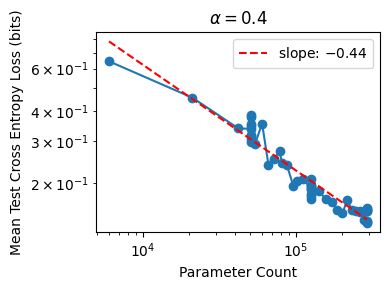

In [112]:
def plot_for_alpha(alpha):
    plt.figure(figsize = (4, 3))

    mean_df = total_df[total_df['alpha'] == alpha].drop("file_name", axis = 1).groupby('hidden_size').mean()
    alpha_df = total_df[total_df['alpha'] == alpha]
    # arjun_filter = alpha_df['file_name'].str.contains('arjun')

    print(mean_df.index)
    param_counts = mean_df.index * 603 + 2
    loss_bits = mean_df[99999] / np.log(2)

    a_param_counts = alpha_df['hidden_size'] * 603 + 2
    a_loss_bits = alpha_df[99999] / np.log(2)

    plt.plot(param_counts, loss_bits)
    plt.scatter(a_param_counts, a_loss_bits)

    a, b = np.polyfit(np.log10(a_param_counts), np.log10(a_loss_bits), deg = 1)

    print(a, b)

    xs = np.linspace(a_param_counts.min(), a_param_counts.max(), 1000)

    plt.plot(xs, 10 ** (a * np.log10(xs) + b), linestyle="dashed", color = "red", label = f"slope: ${a:.2f}$")

    # print(alpha_df['hidden_size'][arjun_filter])
    # print(alpha_df[99999][arjun_filter])
    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Parameter Count")
    plt.ylabel("Mean Test Cross Entropy Loss (bits)")
    plt.legend()
    plt.title(f"$\\alpha = {alpha}$")
    plt.tight_layout()
    plt.savefig(f"images/losses_{alpha}.png", dpi = 600, bbox_inches = "tight")
plot_for_alpha(0.4)

Index([35, 65, 80, 90, 110, 135, 160, 200, 240, 285, 340, 410, 450, 485, 495], dtype='int64', name='hidden_size')
-0.3396973445611426 1.2500612923960162


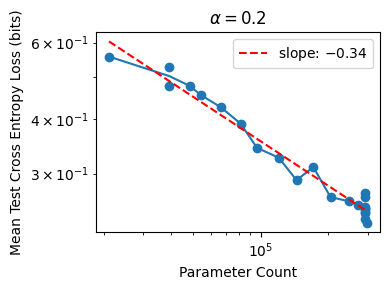

In [113]:
plot_for_alpha(0.2)

Index([35, 65, 80, 90, 110, 135, 160, 200, 240, 285, 340, 410, 450, 485, 495,
       550],
      dtype='int64', name='hidden_size')
-0.6541933947109394 2.2177289409634047


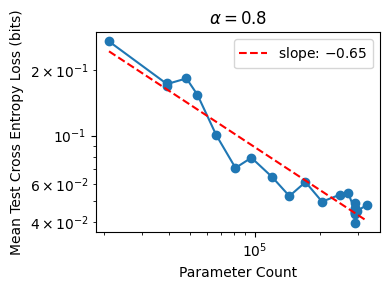

In [114]:
plot_for_alpha(0.8)

## Loss curve over time

[0, 1, 2, 5, 10, 20, 37, 69, 126, 233, 427, 784, 1437, 2636, 4832, 8858, 16237, 29763, 54555, 99999]


/var/folders/4k/5x2z3xbn3nzc6t0xl9rzl_y80000gn/T/ipykernel_71710/1252354368.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple, label = "Steps")


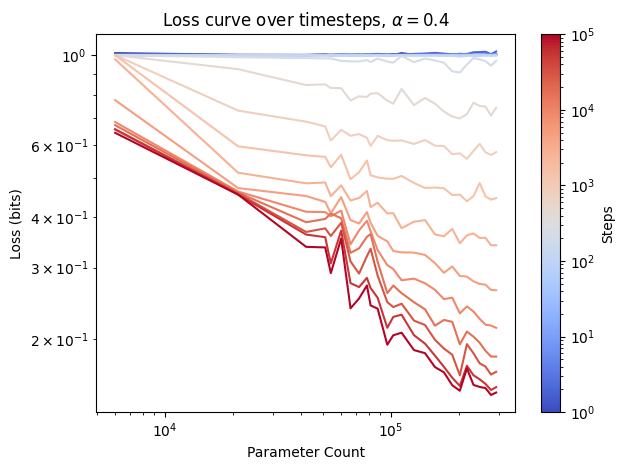

In [23]:
timesteps = 10 ** ((np.linspace(0, 5, 20)))
timesteps = list(np.round(timesteps).astype(int) - 1)
print(timesteps)

# timesteps = list(np.arange(1e4, 1e5 + 1, 1e4, dtype = int) - 1)
alpha = 0.4

alpha_df = total_df[total_df['alpha'] == alpha]

all_runs = alpha_df.loc[:, ['hidden_size'] + timesteps]
mean_df = all_runs.groupby("hidden_size").mean()
params = mean_df.index * 603 + 2
normalize = mcolors.LogNorm(vmin=np.array(timesteps).min() + 1, vmax=np.array(timesteps).max() + 1)
colormap = cm.coolwarm
fig, ax = plt.subplots()

for i in timesteps:
    # plot mean
    plt.plot(params, mean_df[i] / np.log(2), color = colormap(normalize(i + 1)))
    # plt.scatter(all_runs['hidden_size'] * 603 + 2, all_runs[i])
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(timesteps)
plt.colorbar(scalarmappaple, label = "Steps")
plt.xscale("log")
plt.yscale("log")

plt.title("Loss curve over timesteps, $\\alpha = 0.4$")
plt.xlabel("Parameter Count")
plt.ylabel("Loss (bits)")
plt.tight_layout()
plt.savefig(f"images/loss_over_time_{alpha}.png", dpi = 600)
plt.show()


In [198]:
# # contor of the log loss 
# # vs log step size and log param count

# alpha = 0.4

# #step size
# timesteps = np.arange(1e5)
# X = np.log10(timesteps + 1)

# alpha_df = total_df[total_df['alpha'] == alpha]
# mean_df = alpha_df.drop('file_name', axis = 1).groupby("hidden_size").mean()

# #param size
# param_sizes = np.sort(alpha_df['hidden_size'].unique())

# losses = mean_df.drop('alpha', axis = 1).to_numpy()

# fig, ax = plt.subplots(figsize = (8,8))

# plt.xlim([2, 5])

# cf = ax.contourf(X, np.log10(param_sizes * 603 + 2), losses, levels = 10, cmap = cm.coolwarm, norm = "log")
# fig.colorbar(cf, label = "log loss")

# plt.show()


(100000,)
(26,)
(26, 100000)


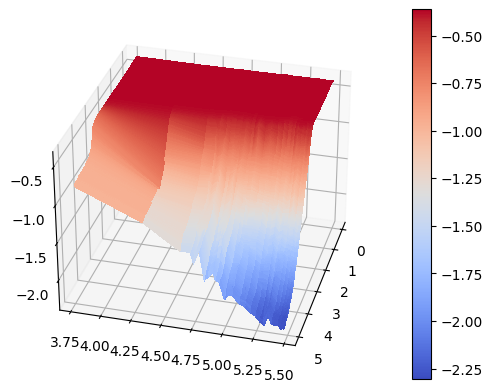

In [80]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

alpha = 0.4


# (log_step_count, log_params, loss)


alpha = 0.4

#step size
timesteps = np.arange(1e5)
X = np.log10(timesteps + 1)

alpha_df = total_df[total_df['alpha'] == alpha]
mean_df = alpha_df.drop('file_name', axis = 1).groupby("hidden_size").mean()

#param size
param_sizes = np.sort(alpha_df['hidden_size'].unique())
Y = np.log10(param_sizes * 603 + 2)

losses = mean_df.drop('alpha', axis = 1).to_numpy()

# plt.xlim([2, 5])

# cf = ax.contourf(X, np.log10(param_sizes * 603 + 2), losses, levels = 10, cmap = cm.coolwarm, norm = "log")
# fig.colorbar(cf, label = "log loss")
print(X.shape)
print(Y.shape)
print(losses.shape)
# plt.xlim([2, 5])
surf = ax.plot_surface(X[None, :], Y[:, None], np.log(losses),
                       linewidth=0, antialiased=False, cmap = cm.coolwarm, shade = False, rcount = 1000, ccount = 10000)
plt.colorbar(surf, ax = ax)

ax.view_init(30, 15)
plt.savefig("images/surface_plot.png", dpi = 600, bbox_inches = "tight")

In [184]:
mean_df.drop('alpha', axis = 1)

0         1         2         3         4         5       
hidden_size                                                               
10           0.701603  0.698129  0.695795  0.695347  0.694340  0.694119  \
35           0.694491  0.694115  0.693962  0.694385  0.693913  0.693645   
70           0.694151  0.693988  0.693674  0.693580  0.693414  0.693941   
85           0.696266  0.694508  0.694408  0.694798  0.694314  0.694157   
90           0.693415  0.695262  0.693586  0.693949  0.694367  0.693712   
100          0.693837  0.696424  0.694205  0.694199  0.694800  0.695082   
110          0.694010  0.695540  0.694006  0.693521  0.694038  0.694358   
120          0.694091  0.696390  0.693513  0.693466  0.694668  0.694095   
130          0.696337  0.693764  0.694686  0.694954  0.693542  0.693482   
135          0.694461  0.696501  0.694010  0.693875  0.694524  0.693981   
145          0.694267  0.698314  0.694282  0.694842  0.695307  0.695384   
160          0.693626  0.696493  0.693696  0.694107  0.695451  0.694021   
170          0.693684  0.697743  0.693936  0.694825  0.695498  0.694135   
185          0.701649  0.693944  0.695714  0.697434  0.695084  0.693982   
210          0.694423  0.698204  0.694121  0.694385  0.695485  0.694645   
235          0.693924  0.699795  0.694081  0.695371  0.696568  0.694953   
260          0.694607  0.702138  0.693964  0.695314  0.697758  0.695485   
285          0.694202  0.699334  0.694447  0.693802  0.695969  0.694862   
310          0.694127  0.696443  0.695208  0.694998  0.693575  0.694091   
335          0.693240  0.693885  0.698808  0.693357  0.695427  0.695756   
360          0.698298  0.697748  0.697221  0.693739  0.694077  0.695758   
385          0.693744  0.704547  0.693521  0.700527  0.699127  0.695476   
410          0.693865  0.705459  0.693694  0.696013  0.699098  0.695821   
435          0.693919  0.706806  0.694247  0.697374  0.699764  0.696720   
460          0.696034  0.697061  0.697305  0.693639  0.695763  0.695713   
485          0.694635  0.707767  0.695354  0.696220  0.699518  0.697678   

                6         7         8         9      ...     99990     99991   
hidden_size                                          ...                       
10           0.693330  0.693153  0.693087  0.693589  ...  0.439116  0.444482  \
35           0.693868  0.694166  0.693331  0.693925  ...  0.308952  0.309215   
70           0.693561  0.693736  0.693524  0.693522  ...  0.230112  0.232088   
85           0.693672  0.693483  0.693507  0.693750  ...  0.227225  0.230265   
90           0.693355  0.693466  0.693565  0.693677  ...  0.196489  0.200497   
100          0.693429  0.693664  0.693357  0.694412  ...  0.238419  0.241870   
110          0.693293  0.693599  0.693322  0.693788  ...  0.159842  0.163979   
120          0.694063  0.693262  0.694214  0.693750  ...  0.171410  0.175230   
130          0.693969  0.693949  0.693390  0.693724  ...  0.183925  0.188248   
135          0.693881  0.693444  0.693875  0.693658  ...  0.165358  0.169306   
145          0.693806  0.693777  0.693415  0.694475  ...  0.160715  0.165157   
160          0.693523  0.693093  0.694394  0.693911  ...  0.130239  0.133686   
170          0.693333  0.693790  0.694864  0.693956  ...  0.137449  0.141593   
185          0.693260  0.693823  0.693394  0.694413  ...  0.138862  0.142708   
210          0.693899  0.693400  0.694212  0.694008  ...  0.125557  0.129624   
235          0.693430  0.693447  0.693259  0.694659  ...  0.122503  0.126907   
260          0.694164  0.693815  0.694842  0.694457  ...  0.114805  0.117807   
285          0.694046  0.693419  0.693958  0.693866  ...  0.110212  0.114456   
310          0.694051  0.693942  0.693508  0.693737  ...  0.103187  0.106030   
335          0.693507  0.694111  0.693731  0.694731  ...  0.100773  0.104077   
360          0.694728  0.693775  0.694037  0.693627  ...  0.114229  0.117468   
385          0.693574  0.695024  0.694658  0.695903  ...  0.101727  0.10485

In [140]:
mean_df

0         1         2         5        10        20   
hidden_size                                                               
10           0.701603  0.698129  0.695795  0.694119  0.693850  0.693155  \
35           0.694491  0.694115  0.693962  0.693645  0.693849  0.693564   
70           0.694151  0.693988  0.693674  0.693941  0.693480  0.693304   
85           0.696266  0.694508  0.694408  0.694157  0.693949  0.693372   
90           0.693415  0.695262  0.693586  0.693712  0.694018  0.693300   
100          0.693837  0.696424  0.694205  0.695082  0.694544  0.693362   
110          0.694010  0.695540  0.694006  0.694358  0.694036  0.693365   
120          0.694091  0.696390  0.693513  0.694095  0.693612  0.693530   
130          0.696337  0.693764  0.694686  0.693482  0.693626  0.693375   
135          0.694461  0.696501  0.694010  0.693981  0.693648  0.693259   
145          0.694267  0.698314  0.694282  0.695384  0.694442  0.693321   
160          0.693626  0.696493  0.693696  0.694021  0.693503  0.693336   
170          0.693684  0.697743  0.693936  0.694135  0.693663  0.693453   
185          0.701649  0.693944  0.695714  0.693982  0.694437  0.693506   
210          0.694423  0.698204  0.694121  0.694645  0.694027  0.693419   
235          0.693924  0.699795  0.694081  0.694953  0.694801  0.693257   
260          0.694607  0.702138  0.693964  0.695485  0.694430  0.693496   
285          0.694202  0.699334  0.694447  0.694862  0.694091  0.693453   
310          0.694127  0.696443  0.695208  0.694091  0.694274  0.693456   
335          0.693240  0.693885  0.698808  0.695756  0.694213  0.693623   
360          0.698298  0.697748  0.697221  0.695758  0.694377  0.693598   
385          0.693744  0.704547  0.693521  0.695476  0.695213  0.693209   
410          0.693865  0.705459  0.693694  0.695821  0.694845  0.693324   
435          0.693919  0.706806  0.694247  0.696720  0.695394  0.693562   
460          0.696034  0.697061  0.697305  0.695713  0.693902  0.693469   
485          0.694635  0.707767  0.695354  0.697678  0.695801  0.693577   

                   37        69       126       233       427       784   
hidden_size                                                               
10           0.693290  0.693035  0.693280  0.693138  0.693128  0.693186  \
35           0.693494  0.693231  0.692983  0.685251  0.640412  0.506411   
70           0.693132  0.693109  0.692952  0.681766  0.585158  0.475606   
85           0.693151  0.693126  0.692862  0.680571  0.587655  0.463084   
90           0.693221  0.693096  0.692806  0.680694  0.575600  0.427400   
100          0.693195  0.692961  0.692721  0.671077  0.575023  0.454038   
110          0.693062  0.693075  0.691307  0.669398  0.536124  0.439050   
120          0.693201  0.693180  0.692693  0.668969  0.549301  0.443280   
130          0.693228  0.693082  0.693044  0.674058  0.547226  0.434266   
135          0.693196  0.693087  0.691521  0.667229  0.557328  0.414609   
145          0.692897  0.693077  0.693133  0.679902  0.558758  0.438981   
160          0.693133  0.693130  0.692238  0.668812  0.535905  0.428325   
170          0.693298  0.693059  0.691463  0.664232  0.526690  0.426865   
185          0.693153  0.693209  0.693113  0.690054  0.572514  0.427577   
210          0.693233  0.693141  0.692100  0.666368  0.522296  0.419102   
235          0.693219  0.693123  0.692196  0.679876  0.544119  0.428808   
260          0.693168  0.693065  0.692737  0.672798  0.526629  0.415074   
285          0.693165  0.693173  0.690965  0.664154  0.503633  0.414307   
310          0.693240  0.693751  0.690997  0.632699  0.489555  0.395616   
335          0.693223  0.692815  0.687504  0.628427  0.484444  0.397508   
360          0.693048  0.693142  0.690540  0.657189  0.496278  0.385211   
385          0.693227  0.693087  0.692493  0.681832  0.529571  0.402981   
410          0.693120  0.693126  0.692979  0.676951  0.519922  0.419546   
435          0.693147  0.693131  0.693085  0

In [32]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# hidden_sizes = srs.index.to_numpy()
# mod_sizes = (hidden_sizes * 603 + 2)
# mean_df = df.T.groupby(level=0).mean()

# # (log_step_count, log_params, loss)
# x_step = 1
# X = np.log10(np.arange(0, 100000, x_step) + 1)
# Y = np.log10(mod_sizes)[:, None]
# Z = [[
#         mean_df.loc[str(hidden_size), x]
#         for x in (np.arange(0, 100000, x_step))] 
#         for hidden_size in hidden_sizes]

# surf = ax.plot_wireframe(X, Y, np.array(Z),
#                        linewidth=1, antialiased=False)
# # ax.view_init(0, 0)

In [33]:
# figure out linear regressions
# make surface plots
# figure out how to check the variance over time or something
# plot loss curve (over parameters) over time (colored)

# Subtask Analysis

In [81]:
def get_big_loss_file(loss_file):
    dirname = os.path.dirname(loss_file)
    aux_info = os.path.splitext(os.path.basename(loss_file))[0][len("losses-"):]
    if dirname.endswith("losses"):
        # is in losses folder
        return f"s3/big_losses/big_losses-{aux_info}.pkl"
    else:
        return f"{dirname}/big_losses-{aux_info}.pkl"

## Phase Transition Variance

In [82]:
def smooth_array(arr, window = 10, mode = "same"):
    return np.convolve(arr, np.ones(10) / 10, mode = mode)

0 0 1
1
0 1 4
1 0 1
1
1 1 4
2 0 1
1
2 1 4


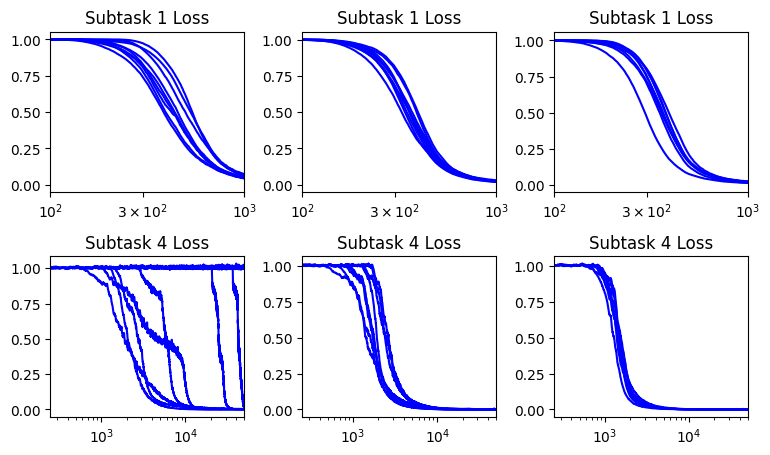

In [121]:
# does the phase transition occur at the same point for every model (i.e. do bigger models learn faster)
# the critical point has low variance, when the task is within capacity:
subtasks = [1, 4]
subtask_lims = {
    1: [150, 1000],
    4: [5 * 50, 5 * 1e4],
}

subtask_ticks = {
    1: [1e2, 3e2, 1e3],
}

fig, ax = plt.subplots(len(subtasks), 3, figsize = (9, 5))

# n_subtasks = 20
# colormap = cm.coolwarm
# normalize = mcolors.Normalize(vmin=1, vmax=n_subtasks + 1)
# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappaple.set_array(np.arange(1, n_subtasks + 1))
# plt.colorbar(scalarmappaple, ax = ax)
model_sizes = [85, 210, 485]
alpha = 0.4

for i in range(3):
    size = model_sizes[i]

    size_df = total_df[(total_df['alpha'] == alpha) & (total_df['hidden_size'] == size)]

    each_loss = {s: [] for s in subtasks}
    mod_cnt = 0
    for fname in (size_df['file_name']):
        bl_name = get_big_loss_file(fname)
        with open(bl_name, "rb") as f:
            bl = pickle.load(f)
            bl = np.array([bl.numpy() for bl in bl])
            for s in subtasks:
                # might want to smooth these
                each_loss[s].append(smooth_array(bl[:, s - 1].ravel()))
        mod_cnt += 1

    for j in (range(mod_cnt)):
        xs = np.arange(20000) * 5 + 1
        for k, s in enumerate(subtasks):
            ax[k, i].plot(xs, each_loss[s][j], color = "blue")
    for k, s in enumerate(subtasks):
        print(i, k, s)
        ax[k, i].set_title(f"Subtask {s} Loss")
        ax[k, i].set_xlim(subtask_lims[s])
        ax[k, i].set_xscale("log")
        if s in subtask_ticks.keys():
            print(s)
            # ax[k, i].get_xaxis().get_major_formatter().labelOnlyBase = False
            # ax[k, i].set_xticks(subtask_ticks[s])
            # ax[k, i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

for b in range(3):
    ax[0, b].set_xticks(subtask_ticks[1])
    ax[0, b].minorticks_off()
plt.subplots_adjust(wspace = 0.3, hspace=0.4)
# fig.tight_layout()
fig.savefig("images/phase_transition_variance.png", dpi = 600, bbox_inches = "tight")
plt.show()

# reference_mods = total_df[(total_df['hidden_size'] == 485) & (total_df['alpha'] == 0.4)]
# for fname in reference_mods['file_name']:
#     bl_name = get_big_loss_file(fname)
#     with open(bl_name, "rb") as f:
#         bl = pickle.load(f)
#     bl = np.array([bl.numpy() for bl in bl])
#     plt.plot(bl[:, 0])
# plt.xscale("log")

## Bigger is Faster

In [143]:

def phase_transition(alpha, subtask, xlims, transparancy, lw = 3):
    a_df = total_df[total_df['alpha'] == alpha]
    normalize = mcolors.Normalize(vmin=a_df['hidden_size'].min(), vmax=a_df['hidden_size'].max())
    colormap = cm.coolwarm
    fig, ax = plt.subplots()
    sizes = np.sort(a_df['hidden_size'].unique())
    sizes = sizes[~np.isin(sizes, [85, 210, 485])]
    for hidden_size in list(sizes) + [85, 210, 485]:
        size_df = a_df[a_df['hidden_size'] == hidden_size]
        avg_loss = np.zeros(20000)
        cnt = 0
        for fname in size_df['file_name']:
            bl_name = get_big_loss_file(fname)
            with open(bl_name, "rb") as f:
                bl = pickle.load(f)
            bl = np.array([bl.numpy() for bl in bl])
            avg_loss += bl[:, subtask]
            cnt += 1
        avg_loss /= cnt
        avg_loss = np.convolve(avg_loss, np.ones(10) / 10, mode = 'same')
        x = np.arange(avg_loss.shape[0])
        if hidden_size in [85, 210, 485]: 
            ax.plot(5 * x + 1, avg_loss, color = 'black', alpha = transparancy, linewidth = 1.4 * lw)
            ax.plot(5 * x + 1, avg_loss, color = colormap(normalize(hidden_size)), alpha = transparancy, linewidth = lw)
        else:
            ax.plot(5 * x + 1, avg_loss, color = colormap(normalize(hidden_size)), alpha = 0.6 * transparancy, linewidth = 0.6 * lw)
    

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(a_df['hidden_size'])
    plt.colorbar(scalarmappaple, ax = ax)
    ax.set_xscale("log")
    ax.set_xlim(xlims)
    ax.set_title(f"Loss on Subtask {subtask + 1}")
    ax.set_xlabel("Steps")
    ax.set_ylabel("Mean Loss (bits)")
    # ax.minorticks_off()
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # ax.set_xticks([xlims[0], xlims[1]])

    fig.tight_layout()
    fig.set_size_inches(3, 3)
    fig.savefig(f"images/subtask_{subtask + 1}_loss_alpha_{alpha}.png", dpi = 600, bbox_inches = "tight")


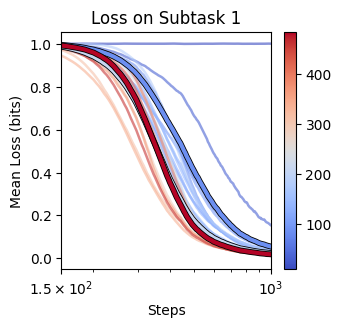

In [141]:
phase_transition(0.4, 0, [150, 1000], 1)

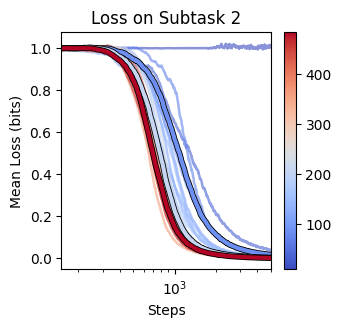

In [144]:
phase_transition(0.4, 1, [5 * 30, 5 * 1000], 1)

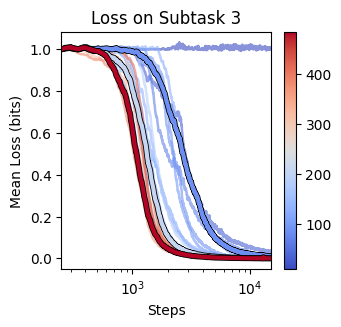

In [145]:
phase_transition(0.4, 2, [5 * 50, 5 * 3000], 1)

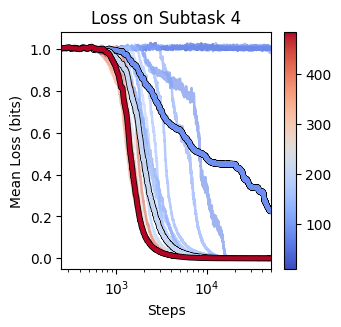

In [146]:
phase_transition(0.4, 3, [5 * 50, 5 * 1e4], 1)

In [ ]:
# look at a scatter of time to learn vs model size, have multiple sets of dots for each subtask

# Differences in capacity

In [32]:
# look at differences in capacity
# show the task count learned is higher for larger ones
# they are trained till the loss flattens (?) <- check this honestly
model_sizes = [85, 210, 485]
alpha = 0.4

100%|██████████| 20/20 [00:00<00:00, 2130.12it/s]


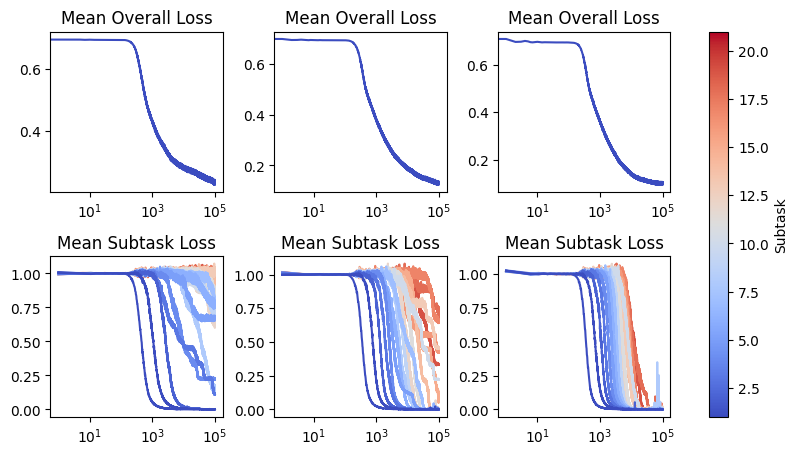

In [42]:
fig, ax = plt.subplots(2, 3, figsize = (10, 5))

n_subtasks = 20
colormap = cm.coolwarm
normalize = mcolors.Normalize(vmin=1, vmax=n_subtasks + 1)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(np.arange(1, n_subtasks + 1))
# plt.colorbar(scalarmappaple, ax = ax)

for i in range(3):
    size = model_sizes[i]

    size_df = total_df[(total_df['alpha'] == 0.4) & (total_df['hidden_size'] == size)]
    # average over the runs 
    main_loss = np.zeros(100000)
    n_losses = np.zeros((n_subtasks, 20000))
    cnt = 0
    for fname in tqdm(size_df['file_name']):
        with open(fname, "rb") as f:
            main_loss += np.array(pickle.load(f))

        bl_name = get_big_loss_file(fname)
        with open(bl_name, "rb") as f:
            bl = pickle.load(f)
            bl = np.array([bl.numpy() for bl in bl])
            n_losses += bl[:, :n_subtasks].T
            cnt += 1
    n_losses /= cnt
    main_loss /= cnt
    ax[0, i].plot(main_loss, color = colormap(normalize(0)))
    for j in tqdm(list(range(n_subtasks))[::-1]):
        xs = np.arange(20000) * 5 + 1
        ax[1, i].plot(xs, (n_losses[j]), color = colormap(normalize(j)))
    ax[1, i].set_xscale("log")
    ax[1, i].set_title("Mean Subtask Loss")
    ax[0, i].set_title("Mean Overall Loss")
    ax[0, i].set_xscale("log")
plt.subplots_adjust(wspace = 0.3, hspace=0.4)
fig.colorbar(scalarmappaple, ax=ax.ravel().tolist(), label = "Subtask")
fig.savefig("images/capacity.png", bbox_inches = "tight")
plt.show()

# Critical Example Counts

/var/folders/4k/5x2z3xbn3nzc6t0xl9rzl_y80000gn/T/ipykernel_71710/54371029.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple)


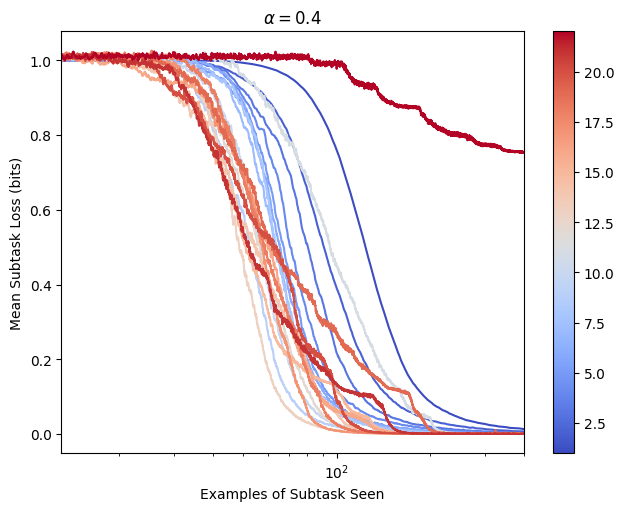

In [89]:
# something we noticed when playing with the models in Michaud's paper is that if you normalize for the number of examples seen, the subtasks
# get learned at approximately the same time
# this motivates an idea of a critical example cohbnt
# show for model of size 485
# show for average subtask loss

alpha = 0.4
size = 485
n_subtasks = 22

mod_df = total_df[(total_df["hidden_size"] == 485) & (total_df["alpha"] == 0.4)]

n_losses = np.zeros((n_subtasks, 20000))
cnt = 0
normalize = mcolors.Normalize(vmin=1, vmax=n_subtasks)
colormap = cm.coolwarm

for f_name in mod_df['file_name']:
    bl_name = get_big_loss_file(f_name)
    with open(bl_name, "rb") as f:
        bl = pickle.load(f)
    bl = np.array([bl.numpy() for bl in bl])
    n_losses += bl[:, :n_subtasks].T
    cnt += 1
n_losses /= cnt

xs = np.arange(20000) * 5 + 1
power_law = (np.arange(500) + 1) ** (-alpha - 1)
power_law = power_law / power_law.sum()
    


for i in range(n_subtasks):
    plt.plot(xs * power_law[i], smooth_array(n_losses[i]), color = colormap(normalize(i + 1)))
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(np.arange(n_subtasks) + 1)
plt.colorbar(scalarmappaple)
plt.xlim([13, 400])
plt.xscale("log")
plt.tight_layout()
plt.title(f"$\\alpha = {alpha}$")
plt.xlabel("Examples of Subtask Seen")
plt.ylabel("Mean Subtask Loss (bits)")
plt.savefig("images/critical_example_0.4.png", dpi = 600, bbox_inches = "tight")

# Universality of the Critical Example Count

/var/folders/4k/5x2z3xbn3nzc6t0xl9rzl_y80000gn/T/ipykernel_71710/2721545989.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple)


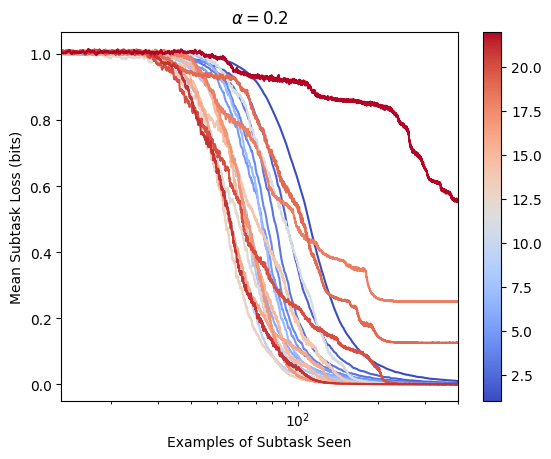

In [88]:
# something we noticed when playing with the models in Michaud's paper is that if you normalize for the number of examples seen, the subtasks
# get learned at approximately the same time
# this motivates an idea of a critical example cohbnt
# show for model of size 485
# show for average subtask loss

alpha = 0.2
size = 485
n_subtasks = 22

mod_df = total_df[(total_df["hidden_size"] == size) & (total_df["alpha"] == alpha)]

n_losses = np.zeros((n_subtasks, 20000))
cnt = 0
normalize = mcolors.Normalize(vmin=1, vmax=n_subtasks)
colormap = cm.coolwarm

for f_name in mod_df['file_name']:
    bl_name = get_big_loss_file(f_name)
    with open(bl_name, "rb") as f:
        bl = pickle.load(f)
    bl = np.array([bl.numpy() for bl in bl])
    n_losses += bl[:, :n_subtasks].T
    cnt += 1
n_losses /= cnt

xs = np.arange(20000) * 5 + 1
power_law = (np.arange(500) + 1) ** (-alpha - 1)
power_law = power_law / power_law.sum()
    


for i in range(n_subtasks):
    plt.plot(xs * power_law[i], smooth_array(n_losses[i]), color = colormap(normalize(i + 1)))
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(np.arange(n_subtasks) + 1)
plt.colorbar(scalarmappaple)
plt.xlim([13, 400])
plt.xscale("log")
plt.title(f"$\\alpha = {alpha}$")
plt.xlabel("Examples of Subtask Seen")
plt.ylabel("Mean Subtask Loss (bits)")
plt.savefig("images/critical_example_0.2.png", dpi = 600, bbox_inches = "tight")

/var/folders/4k/5x2z3xbn3nzc6t0xl9rzl_y80000gn/T/ipykernel_71710/222520001.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(scalarmappaple)


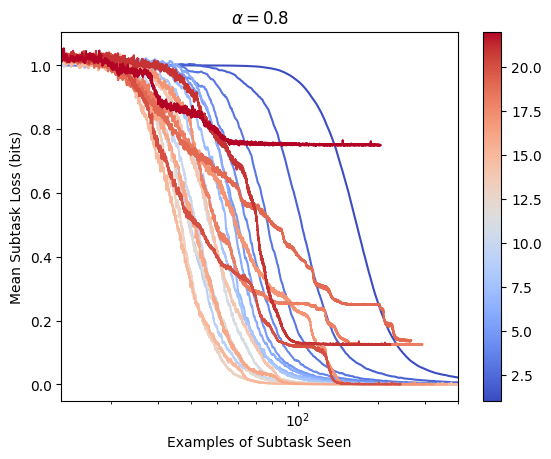

In [90]:
# something we noticed when playing with the models in Michaud's paper is that if you normalize for the number of examples seen, the subtasks
# get learned at approximately the same time
# this motivates an idea of a critical example cohbnt
# show for model of size 485
# show for average subtask loss

alpha = 0.8
size = 485
n_subtasks = 22

mod_df = total_df[(total_df["hidden_size"] == size) & (total_df["alpha"] == alpha)]

n_losses = np.zeros((n_subtasks, 20000))
cnt = 0
normalize = mcolors.Normalize(vmin=1, vmax=n_subtasks)
colormap = cm.coolwarm

for f_name in mod_df['file_name']:
    bl_name = get_big_loss_file(f_name)
    with open(bl_name, "rb") as f:
        bl = pickle.load(f)
    bl = np.array([bl.numpy() for bl in bl])
    n_losses += bl[:, :n_subtasks].T
    cnt += 1
n_losses /= cnt

xs = np.arange(20000) * 5 + 1
power_law = (np.arange(500) + 1) ** (-alpha - 1)
power_law = power_law / power_law.sum()
    


for i in range(n_subtasks):
    plt.plot((xs * power_law[i])[9:], smooth_array(n_losses[i], mode = "valid"), color = colormap(normalize(i + 1)))
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(np.arange(n_subtasks) + 1)
plt.colorbar(scalarmappaple)
plt.xlim([13, 400])
plt.xscale("log")
plt.title(f"$\\alpha = {alpha}$")
plt.xlabel("Examples of Subtask Seen")
plt.ylabel("Mean Subtask Loss (bits)")
plt.savefig("images/critical_example_0.8.png", dpi = 600, bbox_inches = "tight")

In [139]:
a_df['hidden_size'].unique()

array([485,  85, 435, 210, 410, 460,  70, 285, 135, 170, 235, 360, 385,
       310, 100, 145, 260, 335, 110,  90, 185, 120, 130, 160])

In [126]:
bl

[tensor([0.9749, 0.9937, 0.9992, 1.0699, 0.9889, 1.0740, 1.0450, 1.0276, 1.0292,
         1.0265, 1.0202, 1.0390, 1.0006, 1.0478, 1.0540, 1.0791, 1.0286, 1.0632,
         1.0156, 1.0875, 1.0096, 1.0602, 1.0209, 0.9615, 1.0423, 1.0298, 1.0311,
         1.0444, 1.0024, 1.0113, 0.9742, 1.0345, 1.0176, 0.9690, 0.9845, 1.0247,
         0.9900, 1.0364, 1.0186, 1.0290, 1.0180, 0.9997, 1.0168, 1.0390, 1.0328,
         1.0664, 1.0166, 1.0080, 1.0434, 1.0252, 1.0151, 0.9909, 1.0501, 1.0392,
         0.9690, 1.0794, 1.0553, 1.0538, 1.0663, 1.0051, 1.0271, 1.0022, 1.0021,
         1.0328, 0.9875, 1.0450, 1.0366, 1.0031, 1.0329, 1.0382, 1.0007, 1.0228,
         1.0224, 1.0462, 1.0570, 1.0016, 1.0441, 1.0523, 1.0147, 1.0645, 1.0487,
         1.0661, 1.0288, 1.0435, 1.0201, 1.0540, 1.0241, 1.0682, 1.0075, 1.0165,
         1.0081, 1.0185, 1.0068, 1.0354, 0.9944, 1.0022, 1.0350, 0.9808, 1.0550,
         1.0866, 1.0525, 1.0726, 0.9336, 1.0079, 1.0573, 1.0181, 1.0526, 1.0326,
         1.1011, 1.0299, 0.9

In [4]:
mod_state_dict = torch.load("model-110-0-100.pth")

In [12]:
model = nn.Sequential(
    nn.Linear(600, 110),
    nn.ReLU(),
    nn.Linear(110, 2)
)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
count_parameters(model)

66332

In [15]:
(600 + 1) * 110 + (110 + 1) * 2

66332

In [34]:
603 * 110 + 2

66332

In [44]:
(7e4 - 2 ) / 603

116.08291873963516

In [6]:
model.load_state_dict(mod_state_dict)

<All keys matched successfully>

In [7]:
model

Sequential(
  (0): Linear(in_features=600, out_features=110, bias=True)
  (1): ReLU()
  (2): Linear(in_features=110, out_features=2, bias=True)
)

In [1]:
import pickle

with open("losses.pkl", 'rb') as f:
    asdf = pickle.load(f)

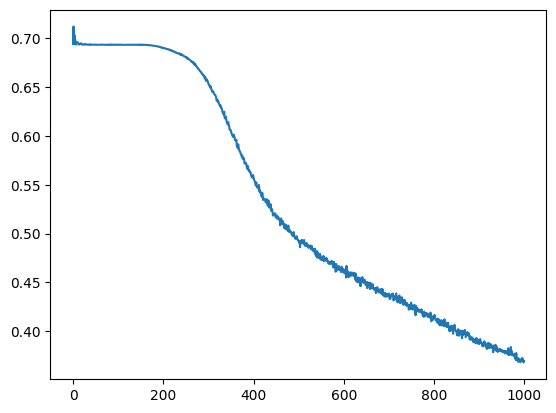

In [2]:
import matplotlib.pyplot as plt

plt.plot(asdf)